In [115]:
import pymysql
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns    

### DB연동

In [143]:
conn = pymysql.connect(host = "127.0.0.1", user = [USER], passwd = [PASSWORD], db = [DATABASE], cursorclass = pymysql.cursors.DictCursor)
cur = conn.cursor()

In [144]:
cur.execute("show databases")
print(cur.fetchall())
cur.execute("use CLI")

[{'Database': 'information_schema'}, {'Database': 'CLI'}, {'Database': 'MusicBank'}, {'Database': 'mysql'}, {'Database': 'mytestdb'}, {'Database': 'performance_schema'}, {'Database': 'sys'}]


0

### DB에서 구글, 카카오, 네이버 포털 트렌드에서 받아온 '경제' 키워드의 검색 비율을 dataframe 'portal_trends_ratio'에 저장

In [145]:
query = """ 
select * from portal_trends_ratio;
"""
cur.execute(query)

portal_trends_ratio = pd.DataFrame(list(cur.fetchall()))
portal_trends_ratio

,id,year,month,day,google,kakao,naver
0,1,2015,9,7,69.0,0.0,0.00000
1,2,2015,9,14,74.0,0.0,0.00000
2,3,2015,9,21,69.0,0.0,0.00000
3,4,2015,9,28,62.0,0.0,0.00000
4,5,2015,10,5,61.0,0.0,0.00000
...,...,...,...,...,...,...,...
264,265,2020,9,28,63.0,19.0,25.29102
265,266,2020,10,5,81.0,21.0,28.63240
266,267,2020,10,12,82.0,24.0,26.85177
267,268,2020,10,19,93.0,21.0,27.25273


### DB에서 Coincident Composite Index을 dataframe 'cci'에 저장

In [119]:
sql = "select * from coincident_composite_index"
cur.execute(sql)
result = cur.fetchall()

conn.close()
cur.close()

In [120]:
cci = pd.DataFrame(result)
cci = cci.drop('id', axis = 1)
cci


,year,month,cci
0,2008,7,100.9
1,2008,8,100.8
2,2008,9,100.8
3,2008,10,100.5
4,2008,11,99.7
...,...,...,...
141,2020,4,97.6
142,2020,5,96.8
143,2020,6,97.0
144,2020,7,97.2


### 세 포털 검색비율이 같은 추세선을 보이는지 확인 (by visualization)

In [146]:
google_naver_kakao = portal_trends_ratio

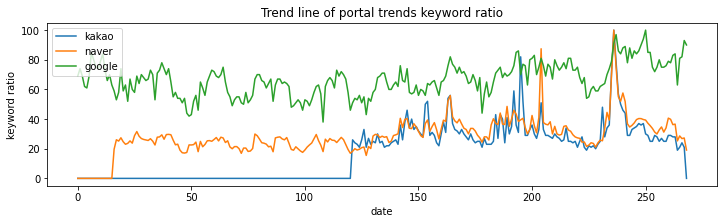

In [147]:
plt.figure(figsize = (12,3))
plt.plot(google_naver_kakao['kakao'], label = 'kakao')
plt.plot(google_naver_kakao['naver'], label = 'naver')
plt.plot(google_naver_kakao['google'], label = 'google')
plt.title("Trend line of portal trends keyword ratio")
plt.xlabel("date")
plt.ylabel("keyword ratio")
plt.legend(loc='upper left')
plt.show()

3개의 포털들의 scale이 너무 달라서, 세 포털의 합/평균을 사용하기에 무리가 있음. 따라서 MinMaxScaler로 구글, 카카오, 네이버 변수간 스케일을 맞춰주고자 함.

In [149]:
# 스케일 조정
scaler = MinMaxScaler()
google_naver_kakao[['google', 'kakao', 'naver']] = scaler.fit_transform(google_naver_kakao[['google', 'kakao', 'naver']])
google_naver_kakao

,id,year,month,day,google,kakao,naver
0,1,2015,9,7,0.500000,0.00,0.000000
1,2,2015,9,14,0.580645,0.00,0.000000
2,3,2015,9,21,0.500000,0.00,0.000000
3,4,2015,9,28,0.387097,0.00,0.000000
4,5,2015,10,5,0.370968,0.00,0.000000
...,...,...,...,...,...,...,...
264,265,2020,9,28,0.403226,0.19,0.252910
265,266,2020,10,5,0.693548,0.21,0.286324
266,267,2020,10,12,0.709677,0.24,0.268518
267,268,2020,10,19,0.887097,0.21,0.272527


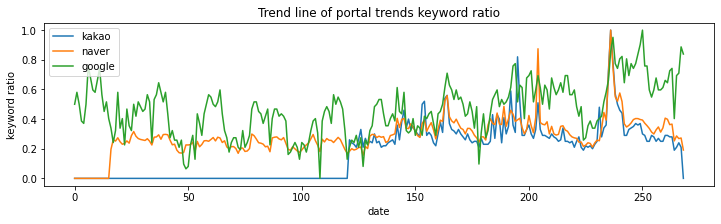

In [123]:
# 스케일 조정 후
plt.figure(figsize = (12,3))
plt.plot(google_naver_kakao['kakao'], label = 'kakao')
plt.plot(google_naver_kakao['naver'], label = 'naver')
plt.plot(google_naver_kakao['google'], label = 'google')
plt.title("Trend line of portal trends keyword ratio")
plt.xlabel("date")
plt.ylabel("keyword ratio")
plt.legend(loc='upper left')
plt.show()

### 2015년부터 데이터를 활용할 수 있도록, 세 개의 포털 검색 비율 변수들을 평균내어 한 개의 변수 생성

In [124]:
"""
2015년 ~ 2016년: 구글 ratio
2016년 ~ 2017년: 구글 + 네이버의 평균 ratio
2018년 ~ 현재: 구글 + 카카오 + 네이버의 평균 ratio

들을 변수 'portals'에 저장
"""
def getAvgOfThreePortalsRatio(google_naver_kakao):
    mean_3portals_list = []

    for i in range(len(google_naver_kakao)):
        portals_ratio = google_naver_kakao.iloc[i][4:7].tolist()
        existedPortalsRatioNum = 3 - portals_ratio.count(0)
        
        # average of portal ratio
        mean_3portals = np.sum( google_naver_kakao.iloc[i].tolist()[4:7] )
        mean_3portals /= existedPortalsRatioNum
        mean_3portals_list.append(mean_3portals)

    return mean_3portals_list

In [125]:
google_naver_kakao['portals'] = getAvgOfThreePortalsRatio(google_naver_kakao)
google_naver_kakao

,id,year,month,day,google,kakao,naver,portals
0,1,2015,9,7,0.500000,0.00,0.000000,0.500000
1,2,2015,9,14,0.580645,0.00,0.000000,0.580645
2,3,2015,9,21,0.500000,0.00,0.000000,0.500000
3,4,2015,9,28,0.387097,0.00,0.000000,0.387097
4,5,2015,10,5,0.370968,0.00,0.000000,0.370968
...,...,...,...,...,...,...,...,...
264,265,2020,9,28,0.403226,0.19,0.252910,0.282045
265,266,2020,10,5,0.693548,0.21,0.286324,0.396624
266,267,2020,10,12,0.709677,0.24,0.268518,0.406065
267,268,2020,10,19,0.887097,0.21,0.272527,0.456541


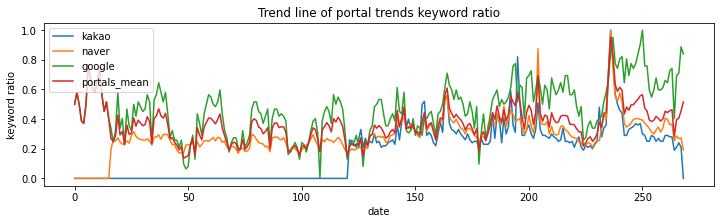

In [126]:
plt.figure(figsize = (12,3))
plt.plot(google_naver_kakao['kakao'], label = 'kakao')
plt.plot(google_naver_kakao['naver'], label = 'naver')
plt.plot(google_naver_kakao['google'], label = 'google')
plt.plot(google_naver_kakao['portals'], label = 'portals_mean')
plt.title("Trend line of portal trends keyword ratio")
plt.xlabel("date")
plt.ylabel("keyword ratio")
plt.legend(loc='upper left')
plt.show()

In [128]:
naver = google_naver_kakao.iloc[16:][['year', 'month', 'day', 'naver']]
naver = naver.reset_index(drop = True)

kakao = google_naver_kakao.iloc[121:][['year', 'month', 'day', 'kakao']]
kakao = kakao.reset_index(drop = True)

google = google_naver_kakao[['year', 'month', 'day', 'google']]
google = google.reset_index(drop = True)


In [129]:
kakao = pd.merge(kakao, portal_trends_ratio)
kakao = kakao[['year', 'month', 'day', 'kakao', 'cci']]

naver = pd.merge(naver, portal_trends_ratio)
naver = naver[['year', 'month', 'day', 'naver', 'cci']]

google = pd.merge(google, portal_trends_ratio)
google = google[['year', 'month', 'day', 'google', 'cci']]

In [130]:
print(kakao[['kakao', 'cci']].corr(method='pearson'))
print()
print(naver[['naver', 'cci']].corr(method='pearson'))
print()
print(google[['google', 'cci']].corr(method='pearson'))

        kakao     cci
kakao  1.0000 -0.1671
cci   -0.1671  1.0000

          naver       cci
naver  1.000000 -0.463341
cci   -0.463341  1.000000

          google       cci
google  1.000000 -0.622731
cci    -0.622731  1.000000


각 포털 검색비율과 CCI 비교한 결과, 카카오의 음의 상관성은 약하다.

In [131]:
google_naver_kakao[['google', 'kakao', 'naver', 'portals']].corr(method='pearson')

,google,kakao,naver,portals
google,1.000000,0.454326,0.464408,0.873793
kakao,0.454326,1.000000,0.760488,0.488357
naver,0.464408,0.760488,1.000000,0.430168
portals,0.873793,0.488357,0.430168,1.000000


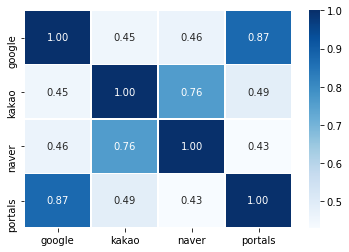

In [132]:
sns.heatmap(data = google_naver_kakao[['google', 'kakao', 'naver', 'portals']].corr(method='pearson'),
            annot=True, 
            fmt = '.2f', 
            linewidths=.5, 
            cmap='Blues')

Pearson 상관계수>

r이 -1.0과 -0.7 사이이면, 강한 음적 선형관계,


r이 -0.7과 -0.3 사이이면, 뚜렷한 음적 선형관계,


r이 -0.3과 -0.1 사이이면, 약한 음적 선형관계,


r이 -0.1과 +0.1 사이이면, 거의 무시될 수 있는 선형관계,


r이 +0.1과 +0.3 사이이면, 약한 양적 선형관계,


r이 +0.3과 +0.7 사이이면, 뚜렷한 양적 선형관계,


r이 +0.7과 +1.0 사이이면, 강한 양적 선형관계

In [133]:
google_naver_kakao = pd.merge(google_naver_kakao, cci)

google_naver_kakao[['cci']] = scaler.fit_transform(google_naver_kakao[['cci']])
google_naver_kakao

,id,year,month,day,google,kakao,naver,portals,cci
0,1,2015,9,7,0.500000,0.00,0.000000,0.500000,0.787234
1,2,2015,9,14,0.580645,0.00,0.000000,0.580645,0.787234
2,3,2015,9,21,0.500000,0.00,0.000000,0.500000,0.787234
3,4,2015,9,28,0.387097,0.00,0.000000,0.387097,0.787234
4,5,2015,10,5,0.370968,0.00,0.000000,0.370968,0.872340
...,...,...,...,...,...,...,...,...,...
256,257,2020,8,3,0.677419,0.25,0.327197,0.418205,0.170213
257,258,2020,8,10,0.596774,0.27,0.346943,0.404572,0.170213
258,259,2020,8,17,0.596774,0.25,0.312279,0.386351,0.170213
259,260,2020,8,24,0.612903,0.25,0.340735,0.401213,0.170213


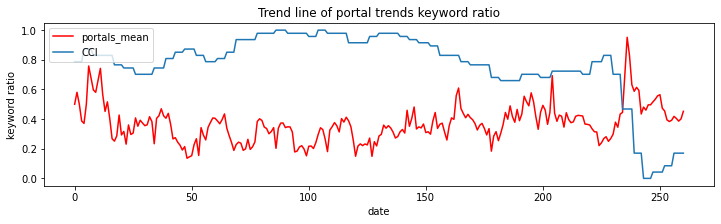

In [134]:
plt.figure(figsize = (12,3))
plt.plot(google_naver_kakao['portals'],color='red', label = 'portals_mean')
plt.plot(google_naver_kakao['cci'], label = 'CCI')
plt.title("Trend line of portal trends keyword ratio")
plt.xlabel("date")
plt.ylabel("keyword ratio")
plt.legend(loc='upper left')
plt.show()

In [135]:
google_naver_kakao[['portals', 'cci']].corr(method='pearson')


,portals,cci
portals,1.000000,-0.455192
cci,-0.455192,1.000000


구글, 카카오, 네이버 변수간 스케일조정을 했음. 구글이 여전히 높은 편이므로 평균 ratio을 활용하면, 구글 데이터만 활용하는 2015-2016년이 높은 값을 갖게 된다.

# 대안

1. 평균 사용대신 CCI와의 음의 상관성이 가장 높은 **구글**만 사용


2. cci와 상관성이 약한 카카오를 제외하고 네이버와 구글을 다른 변수로 16년도부터 사용

### 1. 평균 사용대신 CCI와의 음의 상관성이 가장 높은 구글만 사용

In [165]:
google = portal_trends_ratio[['year', 'month', 'day', 'google']]
google = google.reset_index(drop = True)
google

,year,month,day,google
0,2015,9,7,0.500000
1,2015,9,14,0.580645
2,2015,9,21,0.500000
3,2015,9,28,0.387097
4,2015,10,5,0.370968
...,...,...,...,...
264,2020,9,28,0.403226
265,2020,10,5,0.693548
266,2020,10,12,0.709677
267,2020,10,19,0.887097


In [166]:
google = pd.merge(google, cci)
google

,year,month,day,google,cci
0,2015,9,7,0.500000,100.5
1,2015,9,14,0.580645,100.5
2,2015,9,21,0.500000,100.5
3,2015,9,28,0.387097,100.5
4,2015,10,5,0.370968,100.9
...,...,...,...,...,...
256,2020,8,3,0.677419,97.6
257,2020,8,10,0.596774,97.6
258,2020,8,17,0.596774,97.6
259,2020,8,24,0.612903,97.6


In [167]:
google[['google', 'cci']] = scaler.fit_transform(google[['google', 'cci']])

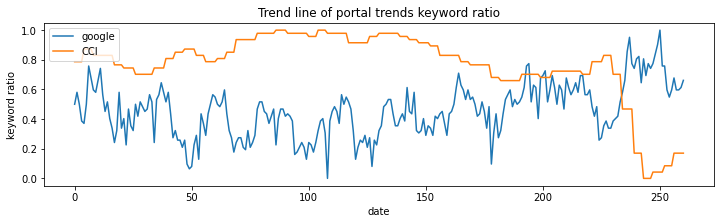

In [168]:
plt.figure(figsize = (12,3))
plt.plot(google['google'], label = 'google')
plt.plot(google['cci'], label = 'CCI')
plt.title("Trend line of portal trends keyword ratio")
plt.xlabel("date")
plt.ylabel("keyword ratio")
plt.legend(loc='upper left')
plt.show()

In [170]:
google[['google', 'cci']].corr(method='pearson')

,google,cci
google,1.000000,-0.622731
cci,-0.622731,1.000000


구글변수는 cci와 음의 상관성이 강하게 있고, 2015년 9월부터 변수로 활용할 수 있으나, 경제지표에 활용할 변수가 구글 1개와 뉴스 키워드포함 기사(5개변수)로 줄어든다. 

### 2. cci와 상관성이 약한 카카오를 제외하고 네이버와 구글을 다른 변수로 16년도부터 사용

In [160]:
google_naver = portal_trends_ratio[['year', 'month', 'day', 'google', 'naver']]
google_naver = google_naver[16:].reset_index(drop = True)
google_naver

,year,month,day,google,naver
0,2015,12,28,0.338710,0.196516
1,2016,1,4,0.241935,0.260585
2,2016,1,11,0.322581,0.251660
3,2016,1,18,0.580645,0.273864
4,2016,1,25,0.338710,0.247262
...,...,...,...,...,...
248,2020,9,28,0.403226,0.252910
249,2020,10,5,0.693548,0.286324
250,2020,10,12,0.709677,0.268518
251,2020,10,19,0.887097,0.272527


In [161]:
google_naver = pd.merge(google_naver, cci)
google_naver

,year,month,day,google,naver,cci
0,2015,12,28,0.338710,0.196516,100.7
1,2016,1,4,0.241935,0.260585,100.4
2,2016,1,11,0.322581,0.251660,100.4
3,2016,1,18,0.580645,0.273864,100.4
4,2016,1,25,0.338710,0.247262,100.4
...,...,...,...,...,...,...
240,2020,8,3,0.677419,0.327197,97.6
241,2020,8,10,0.596774,0.346943,97.6
242,2020,8,17,0.596774,0.312279,97.6
243,2020,8,24,0.612903,0.340735,97.6


In [162]:
google_naver[['google', 'naver', 'cci']] = scaler.fit_transform(google_naver[['google', 'naver', 'cci']])
google_naver

,year,month,day,google,naver,cci
0,2015,12,28,0.338710,0.049329,0.829787
1,2016,1,4,0.241935,0.125134,0.765957
2,2016,1,11,0.322581,0.114574,0.765957
3,2016,1,18,0.580645,0.140846,0.765957
4,2016,1,25,0.338710,0.109371,0.765957
...,...,...,...,...,...,...
240,2020,8,3,0.677419,0.203948,0.170213
241,2020,8,10,0.596774,0.227312,0.170213
242,2020,8,17,0.596774,0.186298,0.170213
243,2020,8,24,0.612903,0.219966,0.170213


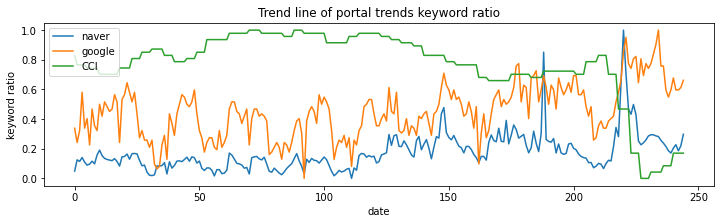

In [163]:
# 스케일 조정
plt.figure(figsize = (12,3))
plt.plot(google_naver['naver'], label = 'naver')
plt.plot(google_naver['google'], label = 'google')
plt.plot(google_naver['cci'], label = 'CCI')
plt.title("Trend line of portal trends keyword ratio")
plt.xlabel("date")
plt.ylabel("keyword ratio")
plt.legend(loc='upper left')
plt.show()

In [164]:
google_naver[['google', 'naver', 'cci']].corr(method='pearson')

,google,naver,cci
google,1.000000,0.700114,-0.649485
naver,0.700114,1.000000,-0.463341
cci,-0.649485,-0.463341,1.000000


구글변수와 네이버변수 모두 cci와 음의 상관성이 있고, 2016년부터는 변수로 모두 활용할 수 있음